In [1]:
from typing import Any, NamedTuple
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import cross_validate
from scipy.io import arff
from sklearn.impute import SimpleImputer


# Type definitions from:
# https://github.com/uci-ml-repo/ucimlrepo?tab=readme-ov-file#parameters
class UciMlData(NamedTuple):
    ids: pd.DataFrame
    features: pd.DataFrame
    targets: pd.DataFrame
    original: pd.DataFrame
    headers: list[str]


class UciMlDataset(NamedTuple):
    data: UciMlData
    metadata: dict[str, Any]
    variables: pd.DataFrame

In [2]:
# pcb: UciMlDataset = fetch_ucirepo(id=365)

# X_pcb = pcb.data.features
# y_pcb = pcb.data.targets

# UCML is not responding


file_name = "./dataset/3year.arff"
data = arff.loadarff(file_name)

X_pcb = pd.DataFrame(data[0])
y_pcb = pd.DataFrame(X_pcb.pop("class"))

y_pcb = pd.DataFrame(y_pcb["class"].apply(lambda x: 1 if x == b"1" else 0))
display(X_pcb.head())
display(y_pcb.head())

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64
0,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.1225,1.1961,0.46359,...,127280.0,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341
1,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.1721,1.6018,0.53962,...,3387.8,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500
2,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.9881,1.0077,0.67566,...,20453.0,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581
3,0.024526,0.43236,0.27546,1.7833,-10.1050,0.56944,0.024526,1.3057,1.0509,0.56453,...,5012.6,0.048398,0.043445,0.95160,0.142980,4.2286,5.0528,98.783,3.6950,3.4844
4,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.4094,1.3393,0.58496,...,13730.0,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375


,class
0,0
1,0
2,0
3,0
4,0


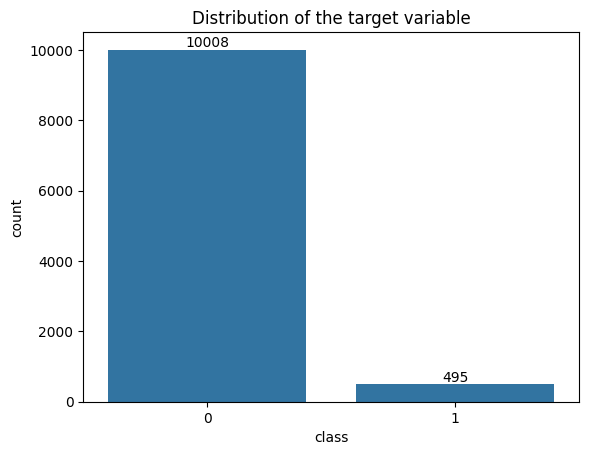

1 - Bankrupt, 0 - Not bankrupt


In [3]:
# Distribution of the target variable
ax = sns.countplot(x=y_pcb.columns[0], data=y_pcb)
plt.title("Distribution of the target variable")
abs_values = y_pcb["class"].value_counts().values
ax.bar_label(ax.containers[0], labels=abs_values, label_type="edge")
plt.show()
print("1 - Bankrupt, 0 - Not bankrupt")

In [4]:
# drop column A37 (based on previous analysis)
print("Drop column Attr37")
X_pcb = X_pcb.drop(columns=["Attr37"])

Drop column Attr37


## Decision Tree Classifier on Iris Dataset with Default Parameters

In [35]:
def run_in_pipeline(X: pd.DataFrame, y: pd.DataFrame, model: Any):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    pipe = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler()),
            ("model", model),
        ]
    )
    pipe.fit(X_train, y_train)

    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)

    print("## TRAIN SET")
    print(classification_report(y_train, y_pred_train))
    print("## TEST SET")
    print(classification_report(y_test, y_pred_test))

    y_pred = pipe.predict(X_test)
    cls = pipe.named_steps["model"]

    return y_test, y_pred, cls

In [36]:
y_test, y_pred, cls = run_in_pipeline(X_pcb, y_pcb, DecisionTreeClassifier())

# print("Classification Report:")
# print(classification_report(y_test, y_pred))

# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred))

## TRAIN SET
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8014
           1       1.00      1.00      1.00       388

    accuracy                           1.00      8402
   macro avg       1.00      1.00      1.00      8402
weighted avg       1.00      1.00      1.00      8402

## TEST SET
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1994
           1       0.42      0.45      0.43       107

    accuracy                           0.94      2101
   macro avg       0.69      0.71      0.70      2101
weighted avg       0.94      0.94      0.94      2101



## Visualize tree

In [33]:
def plot_pcb_tree(
    clf: DecisionTreeClassifier, title: str = "Decision Tree for Iris Dataset"
):
    print(f"Number of nodes: {clf.tree_.node_count}")
    print(f"Depth of tree: {clf.get_depth()}")
    feature_names = X_pcb.columns.to_list()
    class_names = ["0", "1"]
    plt.figure(figsize=(20, 10))
    plot_tree(clf, feature_names=feature_names, class_names=class_names, filled=True)
    # set title
    plt.title(title)
    plt.show()

Number of nodes: 559
Depth of tree: 26


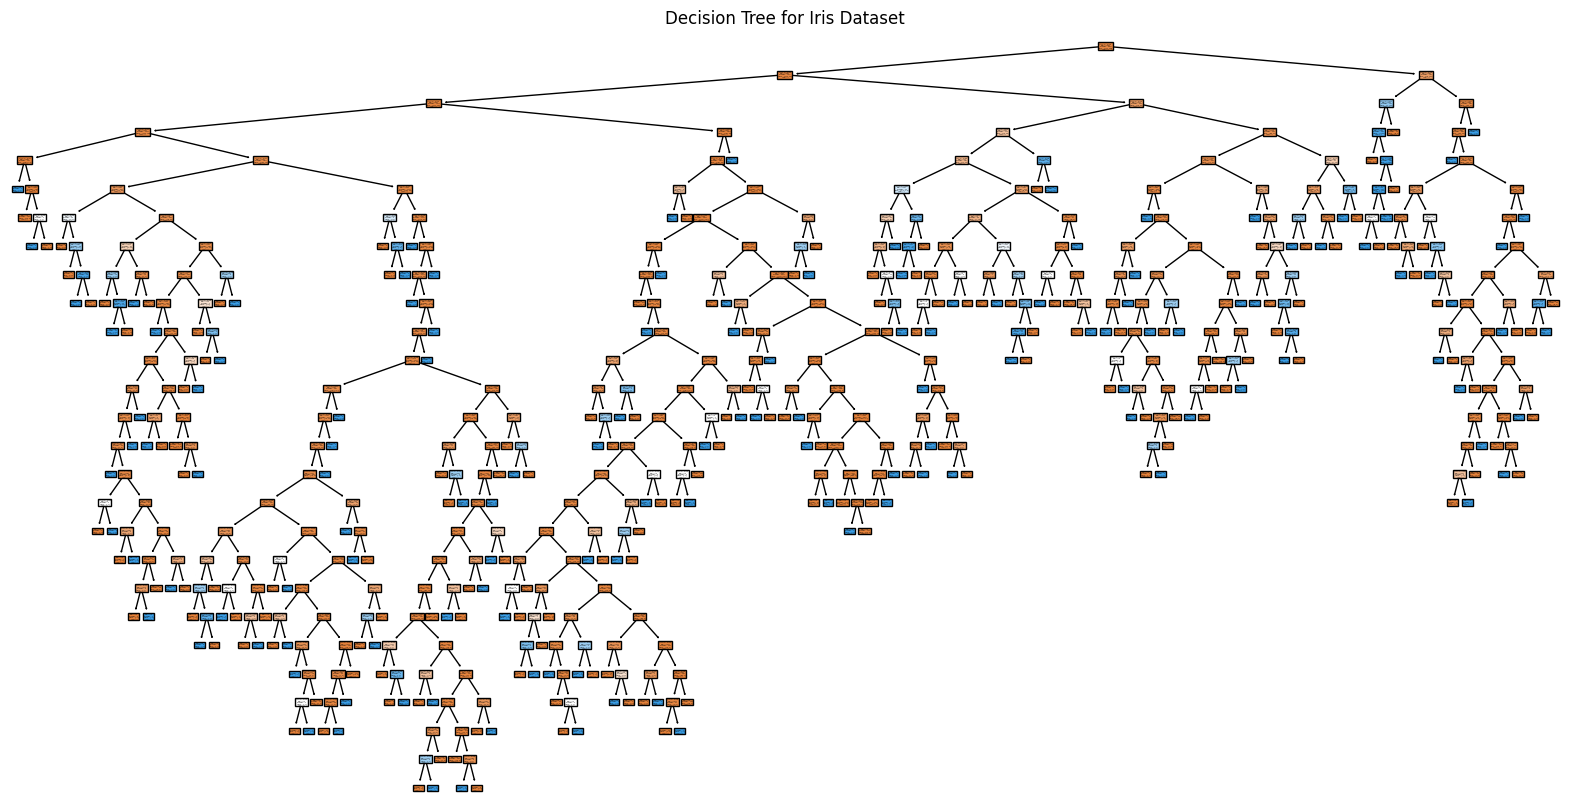

In [37]:
plot_pcb_tree(cls)

## Visualize some decision trees with different params

### Max Depth

## TRAIN SET
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8014
           1       0.92      0.26      0.41       388

    accuracy                           0.96      8402
   macro avg       0.94      0.63      0.69      8402
weighted avg       0.96      0.96      0.96      8402

## TEST SET
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1994
           1       0.90      0.33      0.48       107

    accuracy                           0.96      2101
   macro avg       0.93      0.66      0.73      2101
weighted avg       0.96      0.96      0.96      2101

Number of nodes: 15
Depth of tree: 3


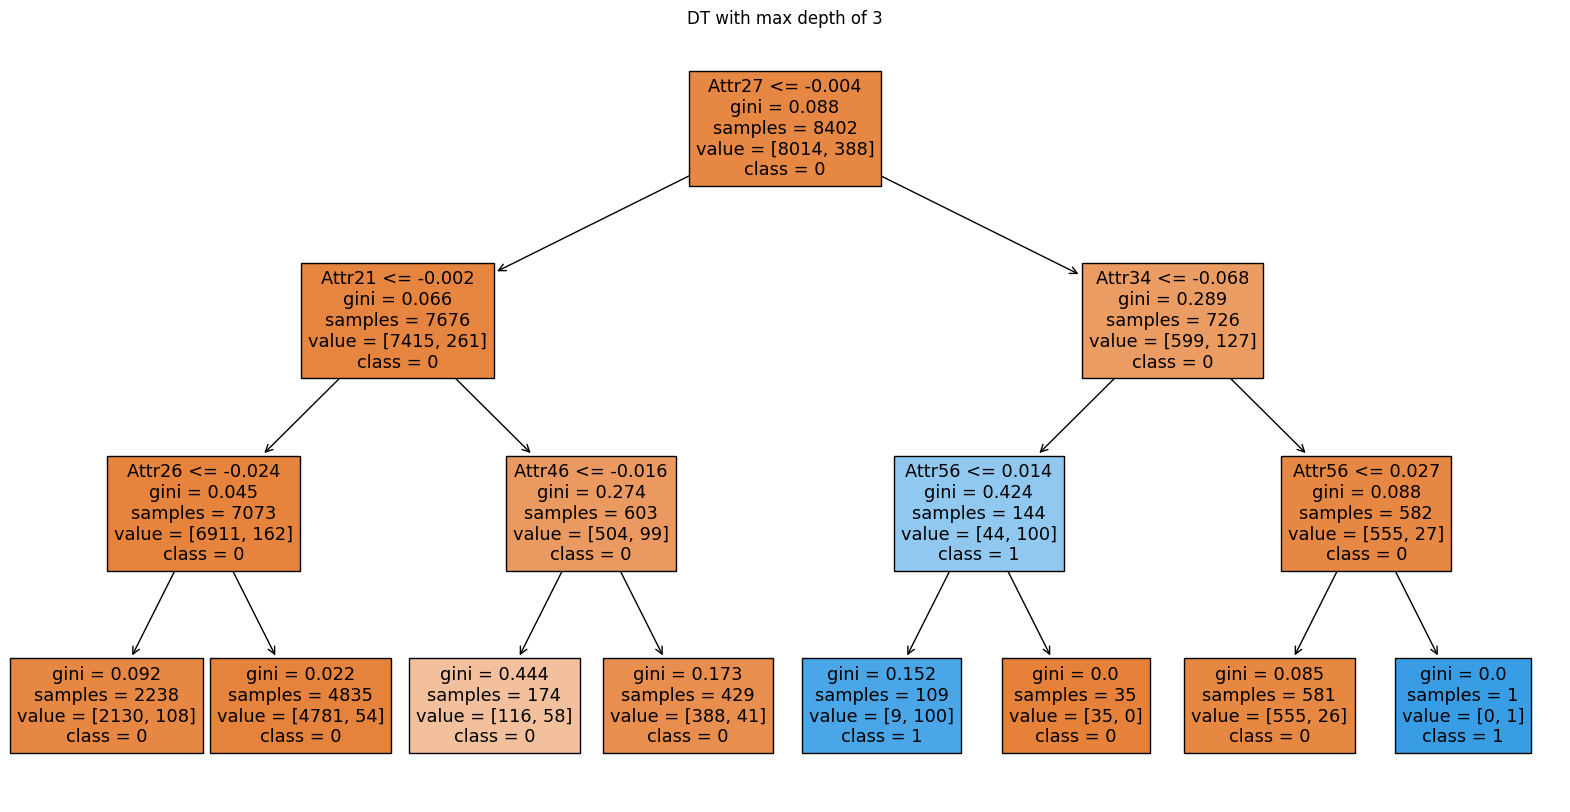

## TRAIN SET
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8014
           1       1.00      0.77      0.87       388

    accuracy                           0.99      8402
   macro avg       0.99      0.88      0.93      8402
weighted avg       0.99      0.99      0.99      8402

## TEST SET
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1994
           1       0.55      0.46      0.50       107

    accuracy                           0.95      2101
   macro avg       0.76      0.72      0.74      2101
weighted avg       0.95      0.95      0.95      2101

Number of nodes: 321
Depth of tree: 13


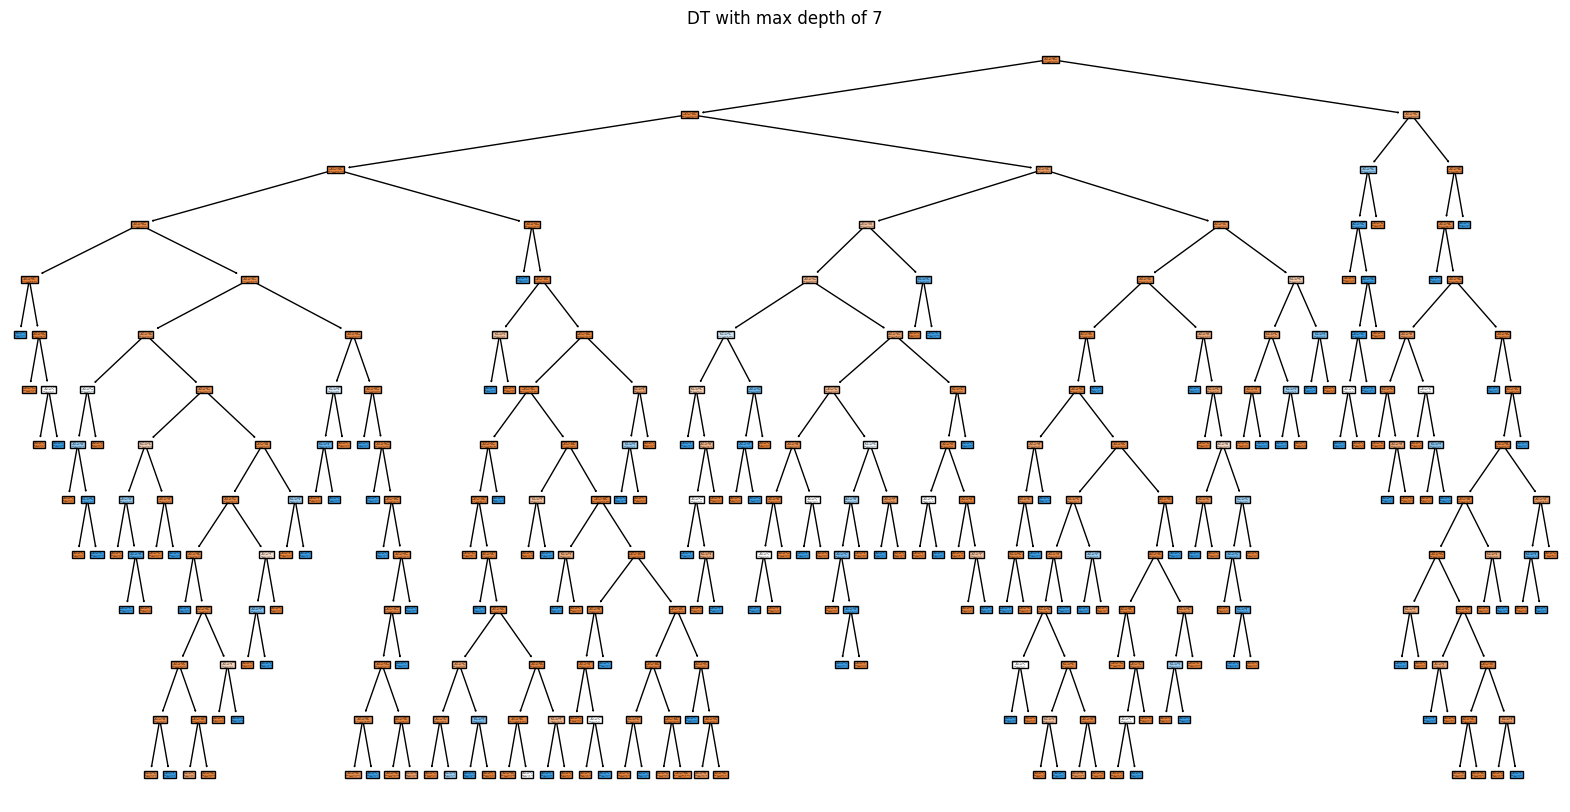

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1994
           1       0.90      0.33      0.48       107

    accuracy                           0.96      2101
   macro avg       0.93      0.66      0.73      2101
weighted avg       0.96      0.96      0.96      2101



In [22]:
# max depth of 3
model = DecisionTreeClassifier(
    ccp_alpha=0.0, criterion="gini", max_depth=3, min_samples_leaf=1
)
y_test, y_pred, cls = run_in_pipeline(X_pcb, y_pcb, model)

plot_pcb_tree(model, "DT with max depth of 3")
# print(classification_report(y_test, y_pred))

# Max depth of 13
model = DecisionTreeClassifier(
    ccp_alpha=0.0, criterion="gini", max_depth=13, min_samples_leaf=1
)
_, _, clf = run_in_pipeline(X_pcb, y_pcb, model)

plot_pcb_tree(clf, "DT with max depth of 7")
print(classification_report(y_test, y_pred))

# max depth parameter conrols the depth of the tree

## TRAIN SET
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8014
           1       0.87      0.38      0.53       388

    accuracy                           0.97      8402
   macro avg       0.92      0.69      0.76      8402
weighted avg       0.97      0.97      0.96      8402

## TEST SET
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1994
           1       0.82      0.35      0.49       107

    accuracy                           0.96      2101
   macro avg       0.89      0.67      0.73      2101
weighted avg       0.96      0.96      0.96      2101

Number of nodes: 45
Depth of tree: 5


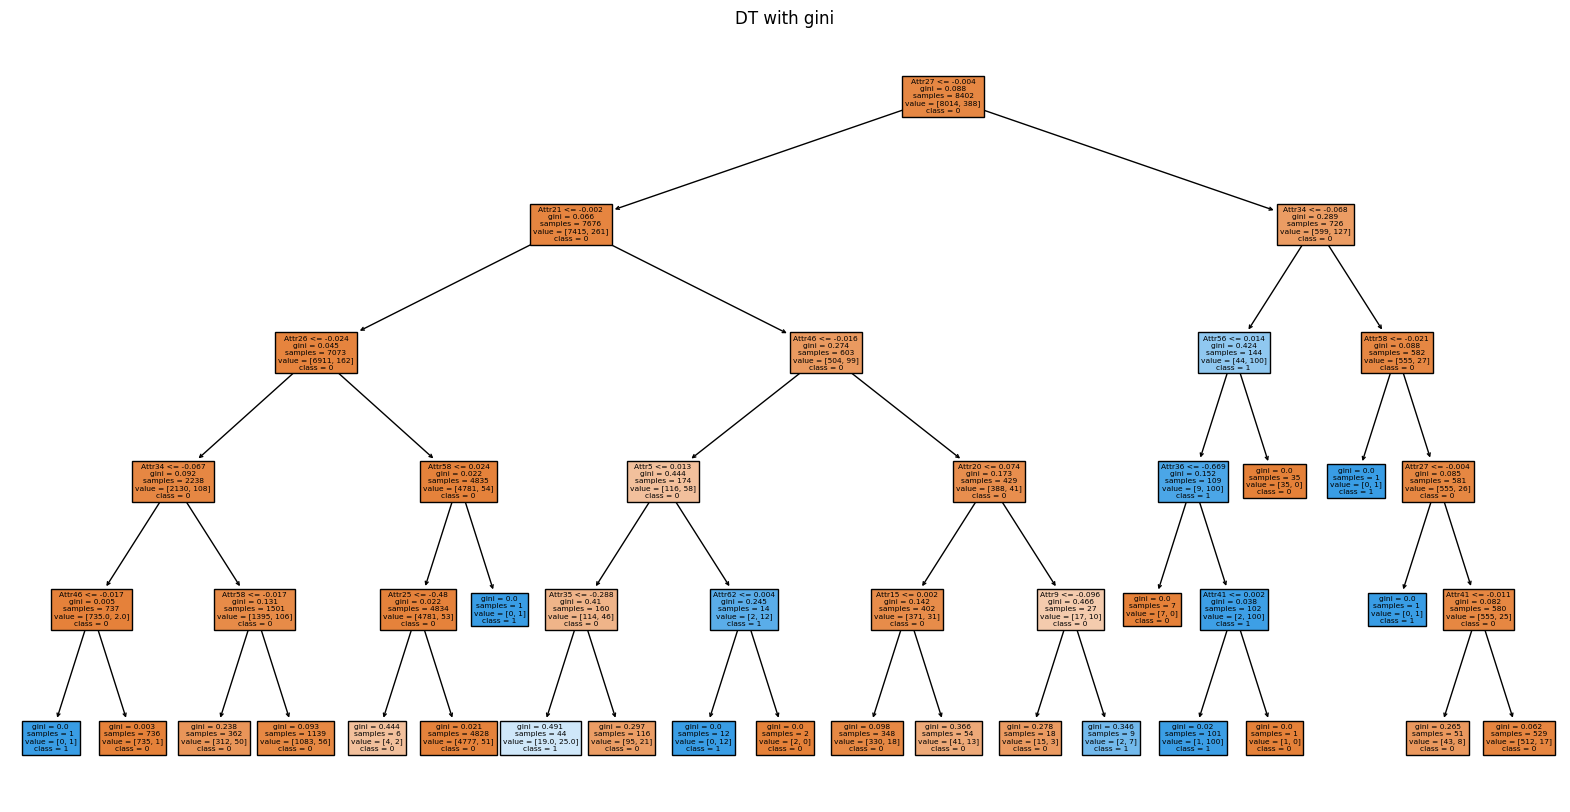

## TRAIN SET
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8014
           1       0.98      0.26      0.41       388

    accuracy                           0.97      8402
   macro avg       0.97      0.63      0.70      8402
weighted avg       0.97      0.97      0.96      8402

## TEST SET
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1994
           1       0.94      0.31      0.46       107

    accuracy                           0.96      2101
   macro avg       0.95      0.65      0.72      2101
weighted avg       0.96      0.96      0.95      2101

Number of nodes: 45
Depth of tree: 5


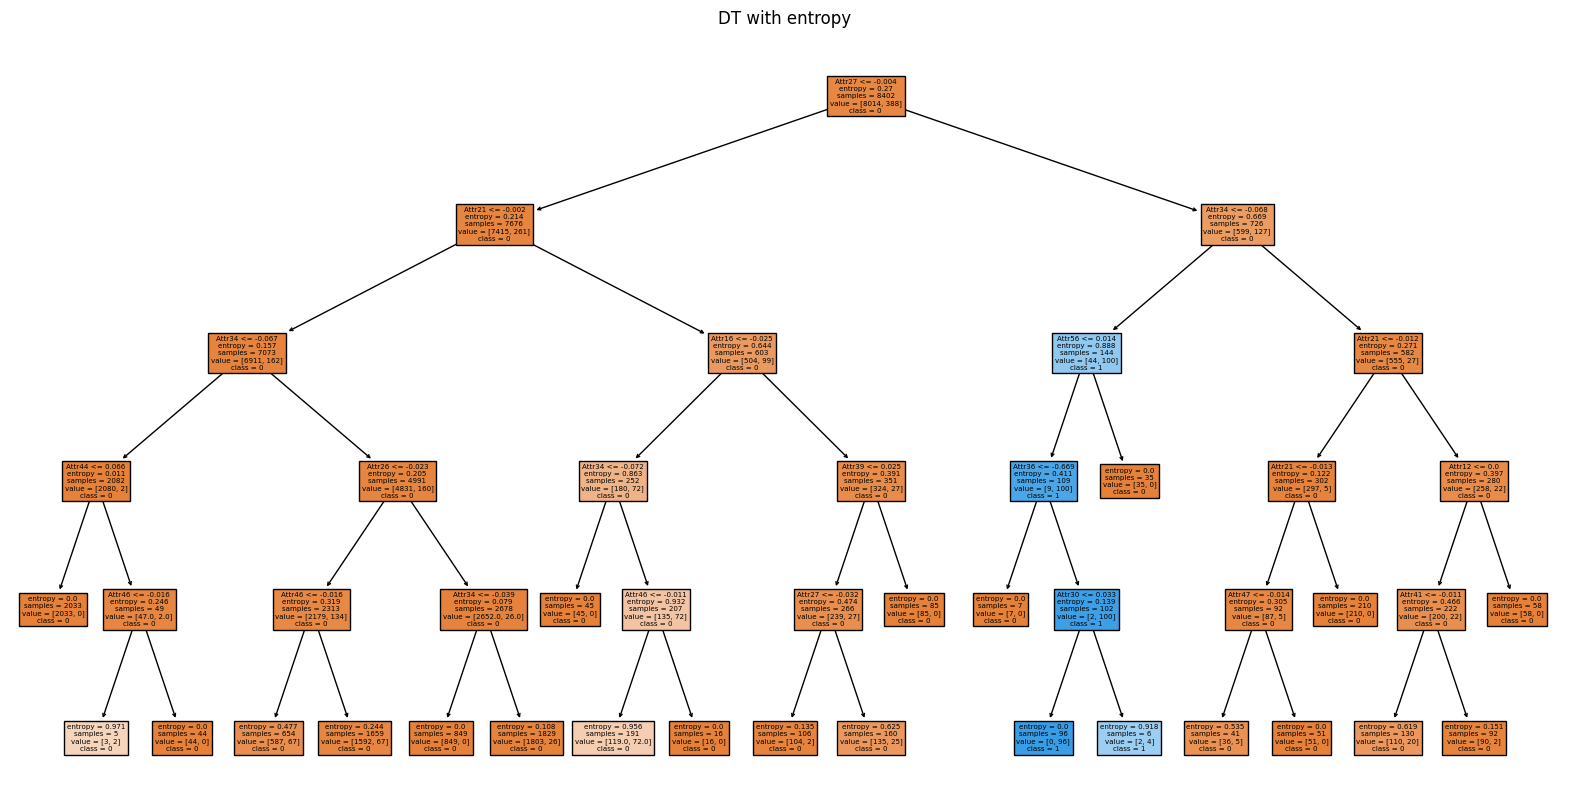

In [24]:
# gini
model = DecisionTreeClassifier(criterion="gini", max_depth=5)

_, _, clf = run_in_pipeline(X_pcb, y_pcb, model)
plot_pcb_tree(clf, "DT with gini")

# entropy
model = DecisionTreeClassifier(criterion="entropy", max_depth=5)
_, _, clf = run_in_pipeline(X_pcb, y_pcb, model)

plot_pcb_tree(clf, "DT with entropy")

# comparison between gini and entropy
# gini - more nodes and larger depth
# entropy - fewer nodes and smaller depth

## TRAIN SET
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8014
           1       0.84      0.41      0.55       388

    accuracy                           0.97      8402
   macro avg       0.91      0.70      0.77      8402
weighted avg       0.97      0.97      0.96      8402

## TEST SET
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1994
           1       0.70      0.36      0.47       107

    accuracy                           0.96      2101
   macro avg       0.83      0.67      0.73      2101
weighted avg       0.95      0.96      0.95      2101

Number of nodes: 55
Depth of tree: 5


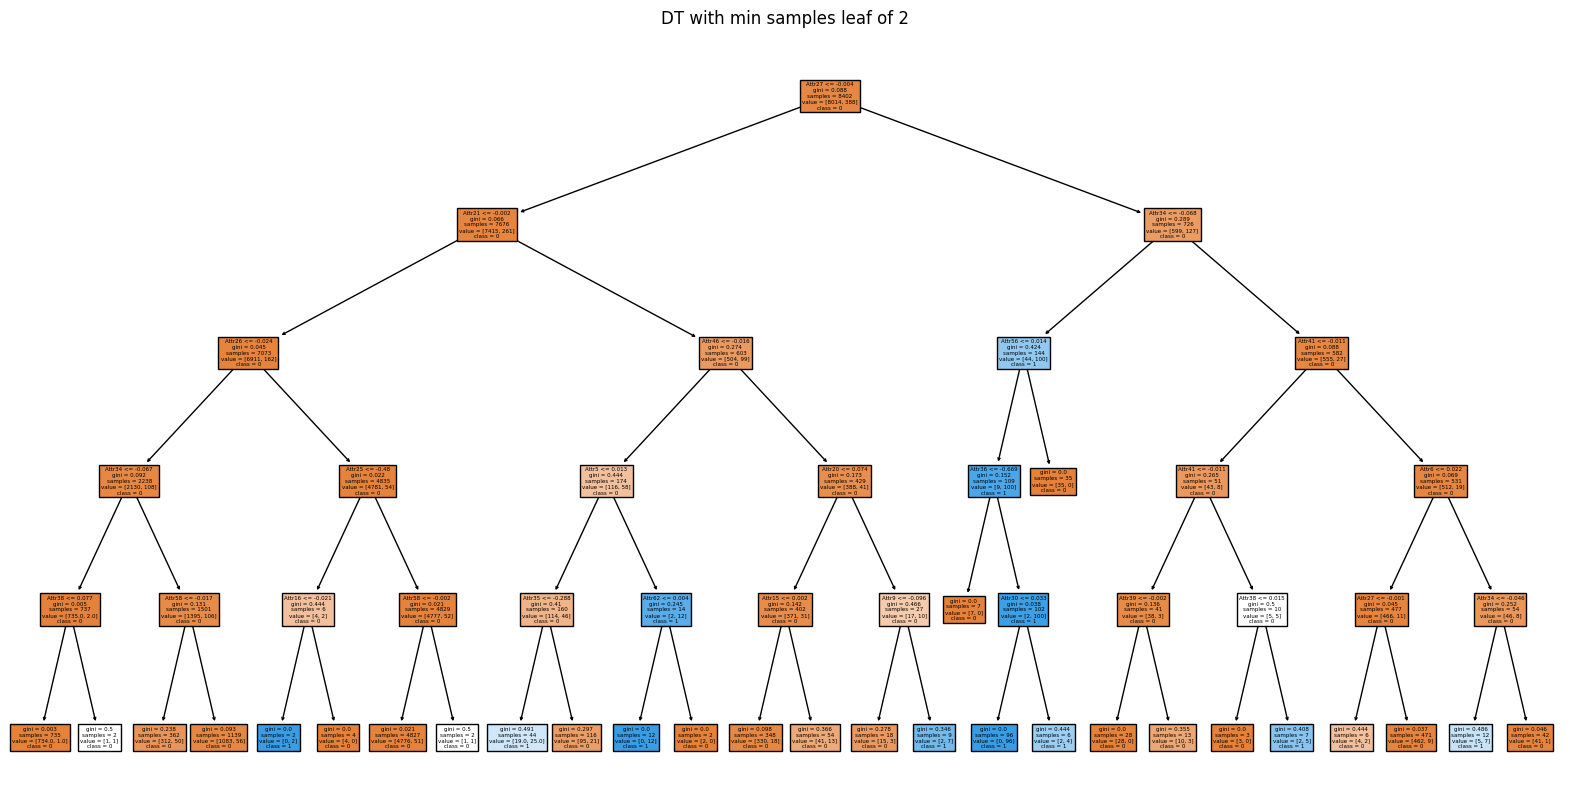

## TRAIN SET
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8014
           1       0.83      0.40      0.54       388

    accuracy                           0.97      8402
   macro avg       0.90      0.70      0.76      8402
weighted avg       0.97      0.97      0.96      8402

## TEST SET
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1994
           1       0.75      0.36      0.48       107

    accuracy                           0.96      2101
   macro avg       0.86      0.67      0.73      2101
weighted avg       0.96      0.96      0.95      2101

Number of nodes: 53
Depth of tree: 5


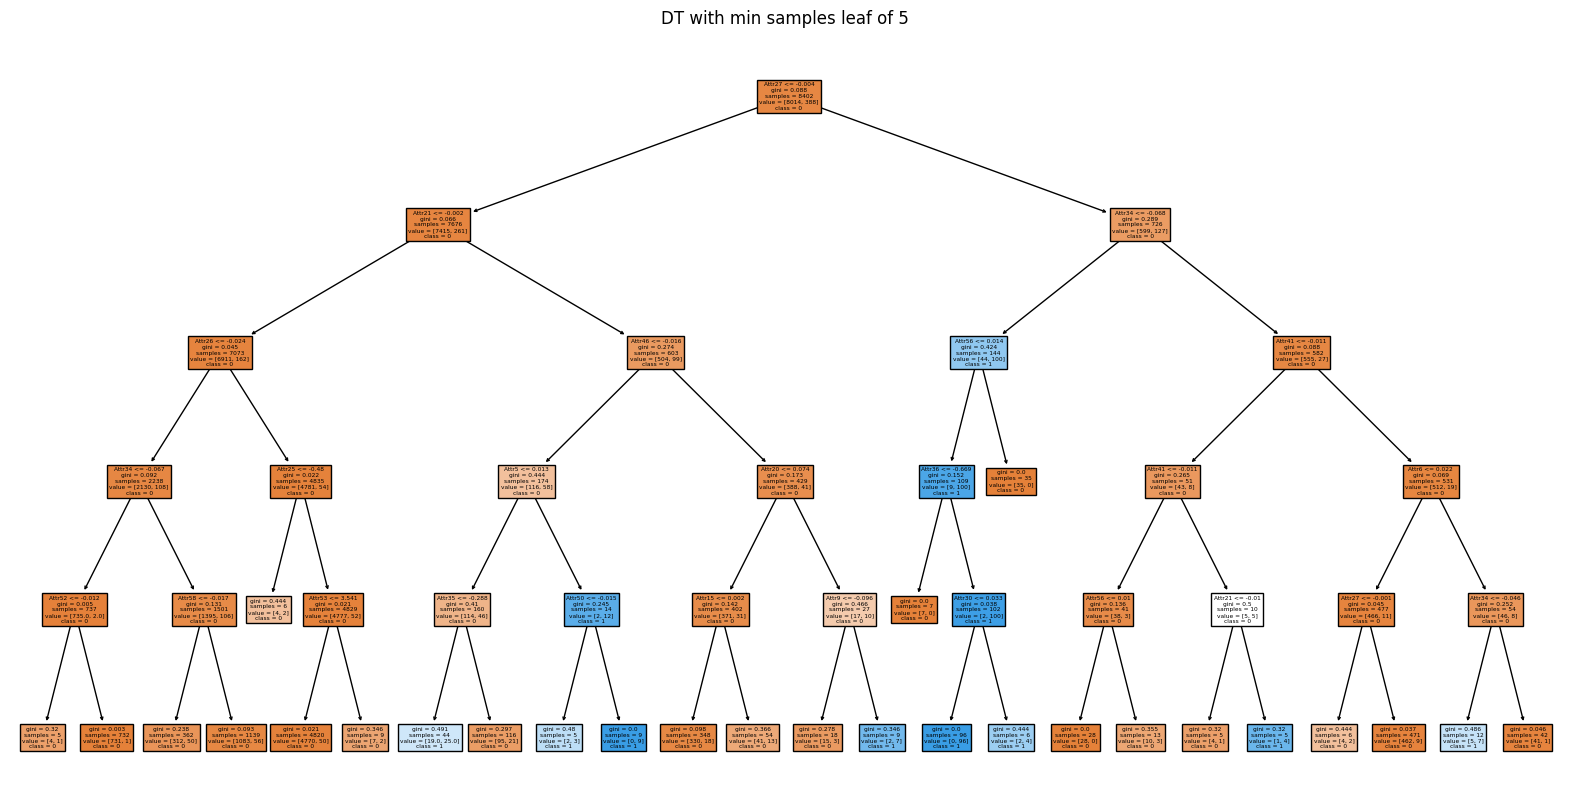

In [25]:
# min samples leaf of 2
model = DecisionTreeClassifier(min_samples_leaf=2, max_depth=5)
_, _, clf = run_in_pipeline(X_pcb, y_pcb, model)
plot_pcb_tree(clf, "DT with min samples leaf of 2")

# entropy
model = DecisionTreeClassifier(min_samples_leaf=5, max_depth=5)
_, _, clf = run_in_pipeline(X_pcb, y_pcb, model)

plot_pcb_tree(clf, "DT with min samples leaf of 5")

# min samples leaf controls the minimum number of samples that a leaf node must contain
# directly influeces tree building process
# larger values preent overfitting
# larger values result in more shallow trees

- min samples leaf controls the minimum number of samples that a leaf node must contain
- larger values preent overfitting
- larger values result in more shallow trees

## Grid search different parameters

In [16]:
def run_grid_search(X: pd.DataFrame, y: pd.DataFrame, param_grid: dict[str, Any]):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    pipe = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler()),
            ("model", DecisionTreeClassifier()),
        ]
    )

    scoring = {
        "AUC": "roc_auc",
        "F1": "f1_micro",
        "Precision": "precision",
        "Recall": "recall",
    }

    grid_search = GridSearchCV(
        pipe, param_grid, scoring=scoring, refit="AUC", return_train_score=True
    )

    grid_search.fit(X_train, y_train)
    return grid_search


# param_grid = {
#     "model__criterion": ["gini", "entropy"],
#     "model__max_depth": [3, 7, None],
#     "model__min_samples_leaf": [1, 5, 20],
#     "model__ccp_alpha": [0.0, 0.01, 0.5],
# }

grid_search = run_grid_search(
    X_pcb,
    y_pcb,
    {
        "model__criterion": ["gini", "entropy"],
        "model__max_depth": [3, 7, None],
        "model__min_samples_leaf": [1, 5, 20],
        "model__ccp_alpha": [0.0, 0.001, 0.01, 0.5],
    },
)
pd.set_option("display.max_rows", None)
print("Best params:", grid_search.best_params_)
# print("Best accuracy score:", grid_search.best_score_)

results_df = pd.DataFrame(grid_search.cv_results_)

# Find the row with the best F1 score
best_f1_index = results_df["mean_test_F1"].idxmax()
best_f1_score = results_df.loc[best_f1_index, "mean_test_F1"]

print("Best f1: ", best_f1_score)

/home/piotr/projects/ai/um-l/l-3/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/piotr/projects/ai/um-l/l-3/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/piotr/projects/ai/um-l/l-3/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

Best params: {'model__ccp_alpha': 0.001, 'model__criterion': 'entropy', 'model__max_depth': 7, 'model__min_samples_leaf': 20}
Best accuracy score: 0.8296594308464608
Best f1:  0.9638182346109175


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_model__ccp_alpha', 'param_model__criterion',
       'param_model__max_depth', 'param_model__min_samples_leaf', 'params',
       'split0_test_AUC', 'split1_test_AUC', 'split2_test_AUC',
       'split3_test_AUC', 'split4_test_AUC', 'mean_test_AUC', 'std_test_AUC',
       'rank_test_AUC', 'split0_train_AUC', 'split1_train_AUC',
       'split2_train_AUC', 'split3_train_AUC', 'split4_train_AUC',
       'mean_train_AUC', 'std_train_AUC', 'split0_test_F1', 'split1_test_F1',
       'split2_test_F1', 'split3_test_F1', 'split4_test_F1', 'mean_test_F1',
       'std_test_F1', 'rank_test_F1', 'split0_train_F1', 'split1_train_F1',
       'split2_train_F1', 'split3_train_F1', 'split4_train_F1',
       'mean_train_F1', 'std_train_F1', 'split0_test_Precision',
       'split1_test_Precision', 'split2_test_Precision',
       'split3_test_Precision', 'split4_test_Precision', 'mean_test_Precision',
       'std_test_P

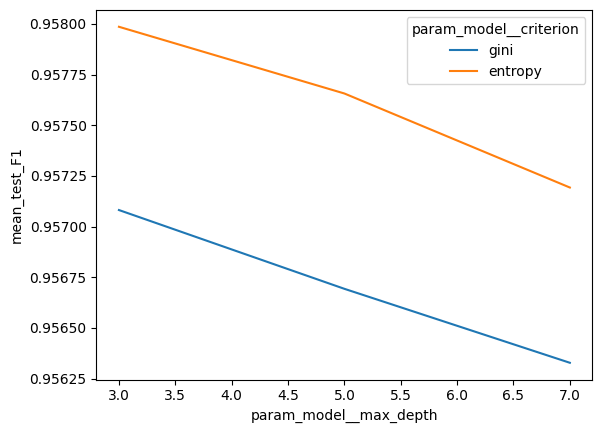

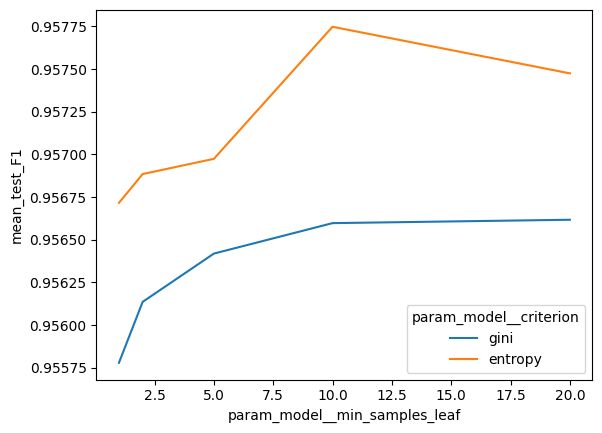

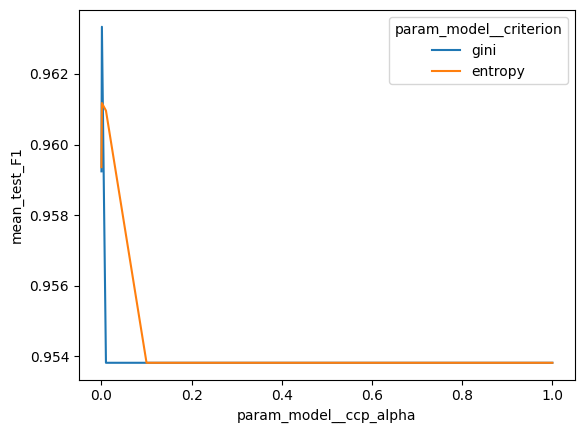

In [14]:
results = grid_search.cv_results_
results_df = pd.DataFrame(results)

# print(results_df.columns)

# chart accuracy by max depth

sns.lineplot(
    data=results_df,
    x="param_model__max_depth",
    y="mean_test_F1",
    hue="param_model__criterion",
    errorbar=None,
)
plt.show()

# chart accuracy by min samples leaf
sns.lineplot(
    data=results_df,
    x="param_model__min_samples_leaf",
    y="mean_test_F1",
    hue="param_model__criterion",
    errorbar=None,
)
plt.show()

# chart accuracy by ccp alpha
sns.lineplot(
    data=results_df,
    x="param_model__ccp_alpha",
    y="mean_test_F1",
    hue="param_model__criterion",
    errorbar=None,
)
plt.show()

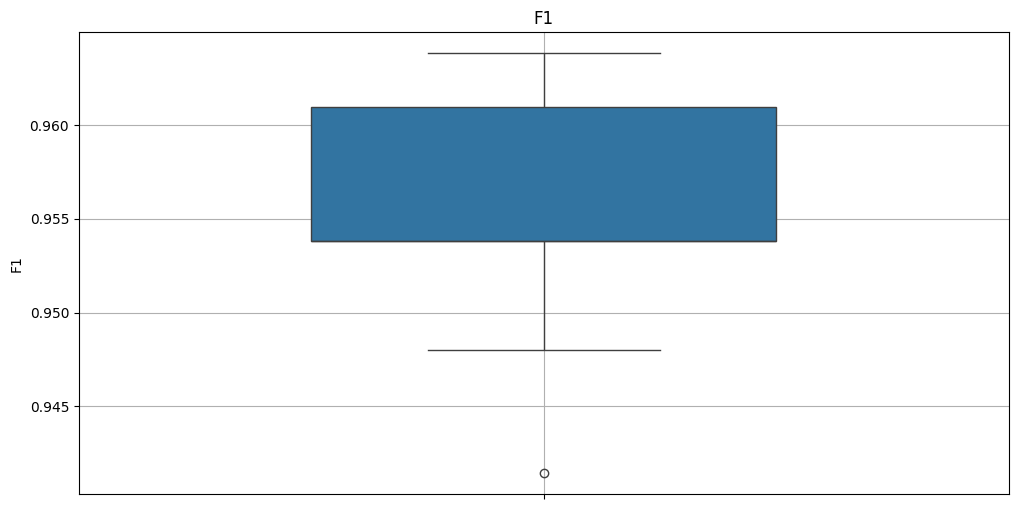

In [15]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df["mean_test_F1"], width=0.5)
plt.title("F1")
plt.ylabel("F1")
plt.xticks(rotation=45, ha="right")
plt.grid(True)
plt.show()

## Cross validation vs stratified cross validation

In [16]:
def perform_cross_validation(
    pipeline: Pipeline,
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    folds: int = 5,
):
    """
    Perform cross-validation and return the mean scores for specified metrics.

    Parameters:
    - pipeline: The machine learning pipeline that includes preprocessing and a classifier.
    - X_train: Training feature set as a pandas DataFrame.
    - y_train: Training target as a pandas Series.
    - folds: Number of cross-validation folds.

    Returns:
    - A dictionary containing mean scores for accuracy, precision, recall, and F1 score.
    """
    scoring = {
        "accuracy": "accuracy",
        "precision": "precision_macro",
        "recall": "recall_macro",
        "f1": "f1_macro",
    }

    cv_results = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=folds)

    mean_scores = {
        metric: np.mean(scores)
        for metric, scores in cv_results.items()
        if "test_" in metric
    }

    return mean_scores

In [31]:
from sklearn.model_selection import KFold, StratifiedKFold

param_grid = {
    "model__criterion": ["gini", "entropy"],
    "model__max_depth": [3, 7, None],
    "model__min_samples_leaf": [1, 5, 20],
    "model__ccp_alpha": [0.0, 0.001, 0.01, 0.5],
}


def run_knn_cross_validation(
    X: pd.DataFrame,
    y: pd.DataFrame,
    K: int = 5,
    stratified: bool = False,
):

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    if stratified:
        kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
    else:
        kf = KFold(n_splits=K, shuffle=True, random_state=42)

    pipe = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler()),
            ("model", DecisionTreeClassifier()),
        ]
    )

    scoring = {
        "AUC": "roc_auc",
        "F1": "f1_micro",
        "Precision": "precision",
        "Recall": "recall",
    }

    grid_search = GridSearchCV(
        pipe, param_grid, cv=kf, refit="F1", scoring=scoring, return_train_score=True
    )

    grid_search.fit(X_train, y_train)
    pd.set_option("display.max_rows", None)

    results_df = pd.DataFrame(grid_search.cv_results_)

    # print(results_df)
    # print(results_df.columns)

    # Find the row with the best F1 score
    best_f1_index = results_df["mean_test_F1"].idxmax()
    best_f1_score = results_df.loc[best_f1_index, "mean_test_F1"]

    return grid_search, best_f1_score

In [32]:
res, f1 = run_knn_cross_validation(X_pcb, y_pcb, 6, stratified=False)
print("Cross validation (without stratification):")
print("Best params: ", res.best_params_)
# print("Best accuracy score: ", res.best_score_)
print("Best F1 score: ", f1)


res, f1 = run_knn_cross_validation(X_pcb, y_pcb, 6, stratified=True)
print("Cross validation with stratification:")
print("Best params: ", res.best_params_)
# print("Best accuracy score: ", res.best_score_)
print("Best F1 score: ", f1)

/home/piotr/projects/ai/um-l/l-3/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/piotr/projects/ai/um-l/l-3/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/piotr/projects/ai/um-l/l-3/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

Cross validation (without stratification):
Best params:  {'model__ccp_alpha': 0.0, 'model__criterion': 'entropy', 'model__max_depth': 3, 'model__min_samples_leaf': 1}
Best F1 score:  0.9629851976479387


/home/piotr/projects/ai/um-l/l-3/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/piotr/projects/ai/um-l/l-3/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/piotr/projects/ai/um-l/l-3/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

Cross validation with stratification:
Best params:  {'model__ccp_alpha': 0.001, 'model__criterion': 'gini', 'model__max_depth': 7, 'model__min_samples_leaf': 1}
Best F1 score:  0.9642942965908704


Cross validation with stratificaiton vs without stratification 
- stratification ensures  that each fold has approximately the same class distribution as the entire dataset
- accuracy results are better with stratification


## Class_weight parameter

In [128]:
print("Number of samples in each class:")
print(y_pcb.value_counts())

Number of samples in each class:
class
0        10008
1          495
Name: count, dtype: int64


DT (PCB) with class weight
## TRAIN SET
              precision    recall  f1-score   support

           0       1.00      0.72      0.84      8014
           1       0.15      0.99      0.26       388

    accuracy                           0.73      8402
   macro avg       0.57      0.86      0.55      8402
weighted avg       0.96      0.73      0.81      8402

## TEST SET
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      1994
           1       0.15      0.86      0.25       107

    accuracy                           0.73      2101
   macro avg       0.57      0.79      0.54      2101
weighted avg       0.95      0.73      0.81      2101

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      1994
           1       0.15      0.86      0.25       107

    accuracy                           0.73      2101
   macro avg       0.57      0.79      0.54      2101

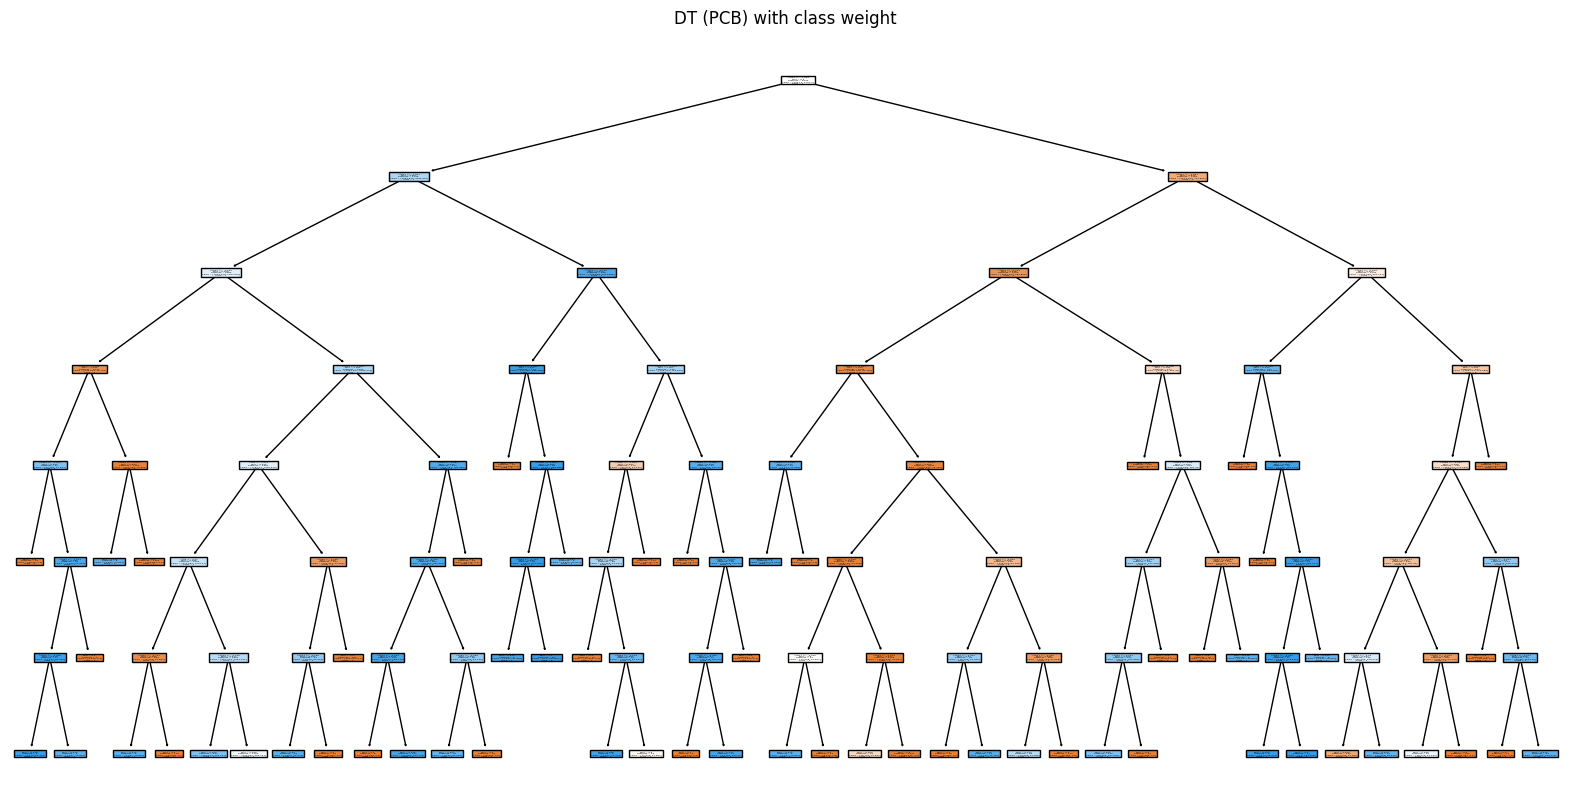

DT (PCB) without class weight
## TRAIN SET
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8014
           1       0.85      0.51      0.63       388

    accuracy                           0.97      8402
   macro avg       0.91      0.75      0.81      8402
weighted avg       0.97      0.97      0.97      8402

## TEST SET
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1994
           1       0.68      0.44      0.53       107

    accuracy                           0.96      2101
   macro avg       0.83      0.71      0.76      2101
weighted avg       0.96      0.96      0.96      2101

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1994
           1       0.68      0.44      0.53       107

    accuracy                           0.96      2101
   macro avg       0.83      0.71      0.76      2

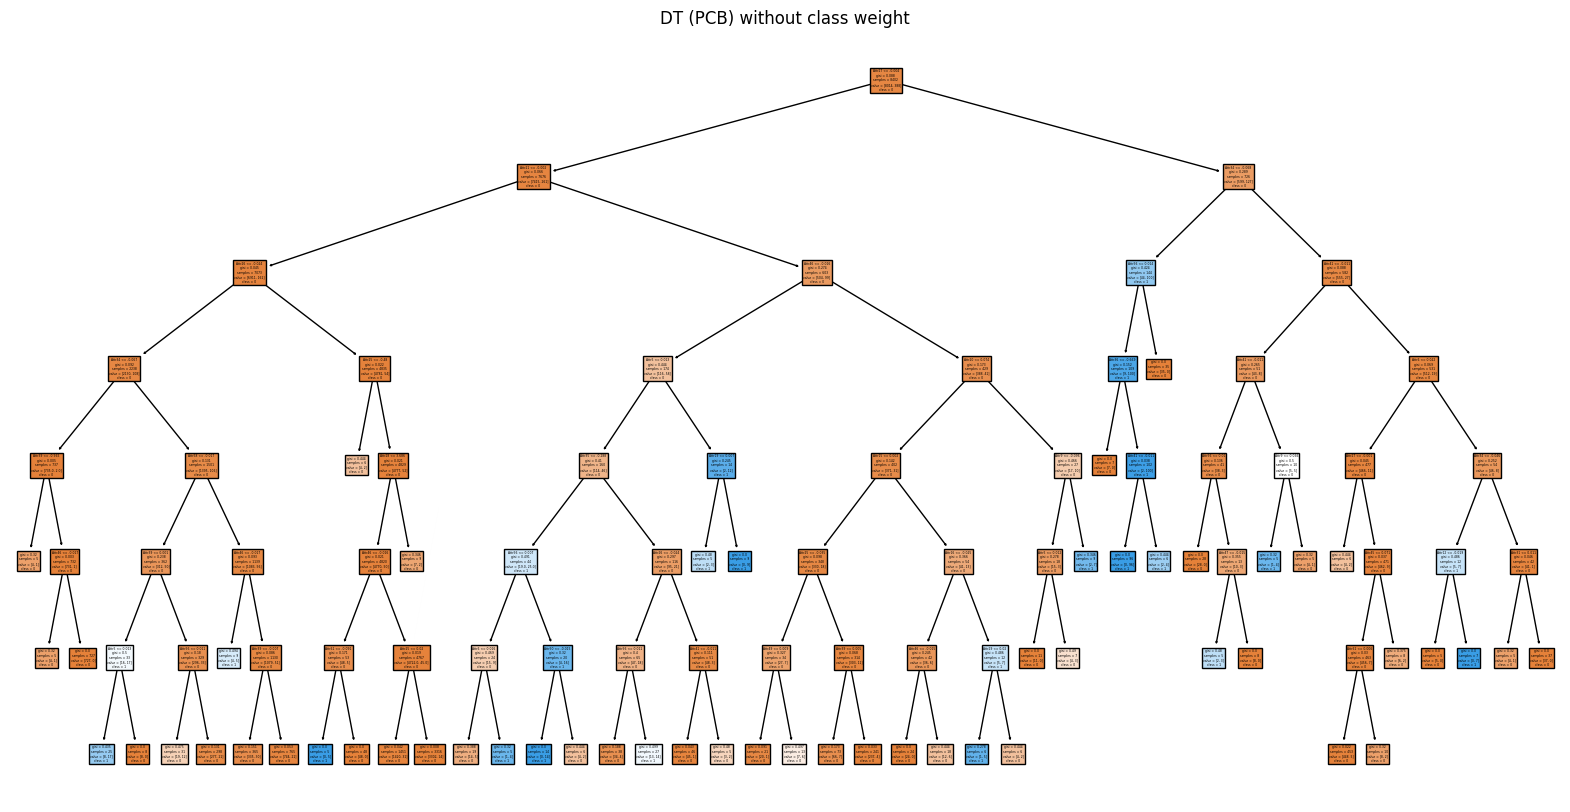

In [27]:
clf_with_class_weight = DecisionTreeClassifier(
    class_weight="balanced", min_samples_leaf=5, max_depth=7
)
# The “balanced” mode uses the values of y to automatically adjust weights
# inversely proportional to class frequencies in the input data
# as n_samples / (n_classes * np.bincount(y))


print("DT (PCB) with class weight")
y_test, y_pred, cls = run_in_pipeline(X_pcb, y_pcb, clf_with_class_weight)
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

plot_pcb_tree(cls, "DT (PCB) with class weight")


print("DT (PCB) without class weight")
y_test, y_pred, cls = run_in_pipeline(
    X_pcb, y_pcb, DecisionTreeClassifier(min_samples_leaf=5, max_depth=7)
)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

plot_pcb_tree(cls, "DT (PCB) without class weight")

# Class weight parameter is used for imbalanced datasets
# It assigns weights to classes to balance the dataset
# with class weight the tree is more complex, because it tries to balance the classes